# **Parameter Optimisation for TSPMe model** 

This notebook is created to provide an example for ```data_fit``` optimisation problem. Selected PyBaMM parameters are optimised in this notebook. Voltage and average cell temperature are considered in the minimasiation algorithm.
This can also be found in `scripts/multiple_variable_fit.py` as Python function. The workflow is as follows:


In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q
import os
os.chdir("../..")
import pybamm
import pbparam
import pandas as pd
import os

os.chdir(os.path.join(pbparam.__path__[0], "input", "data"))

We start by importing the example experimental dataset which corresponds to the [Brosa Planella et al. (2021) article](https://www.sciencedirect.com/science/article/pii/S0013468621008148).

In [2]:
data = pd.read_csv("LGM50_789_1C_25degC.csv")

In order to optimise reaction coefficient, Negative Electrode Exchange-Current Density is tuned by ```j0_neg``` function:

In [3]:
def j0_neg(c_e, c_s_surf, c_s_max, T):
    """
    This function has been copied from the Chen2020 parameter set:
    pybamm/input/parameters/lithium_ion/negative_electrodes/graphite_Chen2020
    /graphite_LGM50_electrolyte_exchange_current_density_Chen2020.py
    Similar could be done for the positive exchange current density
    """
    m_ref = pybamm.Parameter("Negative electrode reaction coefficient")
    E_r = 3500
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))
    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )

PyBaMM model to be used for parameter optimisation needs to be defined:

In [4]:
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

Rest of the PyBaMM simulation requirements and initial parameters defined here:

In [5]:
param = pybamm.ParameterValues("Chen2020")  # Initial parameters to be used.

# Update some parameters to match the experimental setup
param.update(
    {
        "Negative electrode diffusivity [m2.s-1]": 2e-14,
        "Initial concentration in positive electrode [mol.m-3]": 17150,
        "Negative electrode exchange-current density [A.m-2]": j0_neg,
        "Negative electrode reaction coefficient": 6.48e-7,
        "Total heat transfer coefficient [W.m-2.K-1]": 16,
        "Ambient temperature [K]": 297.825,
        "Initial temperature [K]": 297.825,
    },
    check_already_exists=False,
)


experiment = pybamm.Experiment(
    [
        "Discharge at 1C until 2.5 V",
        "Rest for 2 hours",
    ],
    period="30 seconds",
)

simulation = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=experiment,
)

PyBaMM-param needs a dictionary for parameters to be optimised in ```{"parameter name": (initial guess, (lower bound, upper bound))}```

In [6]:
param_optimise = {
    "Negative electrode diffusivity [m2.s-1]": (5e-14, (2.06e-16, 2.06e-12)),
    "Negative electrode reaction coefficient": (
        6.48e-7,
        (2.18589831e-9, 2.18589831e-5),
    ),
    "Total heat transfer coefficient [W.m-2.K-1]": (20, (0.1, 1000)),
    (
        "Positive current collector specific heat capacity [J.kg-1.K-1]",
        "Negative current collector specific heat capacity [J.kg-1.K-1]",
        "Negative electrode specific heat capacity [J.kg-1.K-1]",
        "Separator specific heat capacity [J.kg-1.K-1]",
        "Positive electrode specific heat capacity [J.kg-1.K-1]",
    ): (2.85e3, (2.85, 2.85e6)),
}

Which variables will be considered should be provided in a list. If different weights wanted for each variables, it should be provided here (optional):

In [7]:
variables_to_fit = ["Voltage [V]", "X-averaged cell temperature [K]"]
variable_weights = {"X-averaged cell temperature [K]": [2], "Voltage [V]": [1]}

Firstly, cost funtion for optimisation algorithm should be defined. Then, optimisation problem with PyBaMM simulation, experimental data, dictionary of parameters with initial guesses and bounds, variables to be optimised, variable weights and cost function should be passed.

In [8]:
cost_function = pbparam.MLE()
# Since this is a parameter optimisation with fitting data into experimental data, optimisation problem is DataFit.
opt = pbparam.DataFit(
    simulation,
    data,
    param_optimise,
    variables_to_fit,
    pbparam.MLE(),
    variable_weights,
)

Then, Optimisation method should be defined in this step. DiferentialEvolution(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) or ScipyMinimize(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)
or Pymoo (https://pymoo.org/index.html)

can be used to minimise cost function. For faster results, ScipyMinimize with ```"Nelder-Mead"``` method can be used. However, ScipyDifferentialEvolution is more robust and has provided lower value for most of the cases. Pymoo is a Multi-objective Optimisation tool and it has many methods.

In [9]:
# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
# )
#optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")
optimiser = pbparam.PymooMinimize()

After providing everything for optimisation algorithm, it can be performed using `optimise(optimisation_problem)`

In [10]:
result = optimiser.optimise(opt)
# optimised values of parameters and function values can be printed as below.
print(result)


             Optimal values: [1.81810520e-14 2.68395205e-07 3.52983572e+01 2.00995902e+03
 3.75152117e-02 4.76121260e-01]
        Cost function value: -12881.76357740437
                Solver name: PyMoo Minimize optimiser with <class 'pymoo.algorithms.soo.nonconvex.pso.PSO'> method
                 Solve time: 39 minutes, 35 seconds
                    Message: None
        


```plot()``` function can be used to present result graphically.

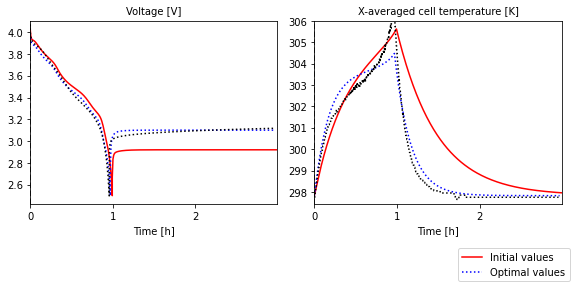

In [11]:
result.plot()